# Video Lesson \#15

## Part 2: `pandas` - correlating, resampling, and smoothing data

In [1]:
# Import useful libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

### Load weather station data from Seattle and Spokane 

**Data source:** NOAA NCDC [Climate Data Online](https://www.ncdc.noaa.gov/cdo-web/)

**Description:** Daily high/low temperature (in °F) and precipitation (in/day) from 1980-present for SeaTac (station #24233) and Spokane (station #24157).

In [2]:
# Load CSV
# Note that we're parsing the "eventDate" column as datetimes
#   and setting the "recordNumber" column as the index
wa_filepath = 'data/wa_weather.csv'
wa_data = pd.read_csv(wa_filepath, parse_dates=['DATE'])

# View data
display(wa_data)

,STATION,NAME,DATE,PRCP,TMAX,TMIN
0,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-01,0.22,52.0,44.0
1,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-02,0.19,46.0,37.0
2,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-03,0.00,46.0,33.0
3,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-04,0.13,40.0,34.0
4,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-05,0.12,39.0,30.0
...,...,...,...,...,...,...
32753,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2024-10-30,0.03,51.0,30.0
32754,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2024-10-31,0.34,43.0,37.0
32755,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2024-11-01,0.43,46.0,38.0
32756,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2024-11-02,0.47,47.0,38.0


In [3]:
# Divide the data by location into two Pandas DataFrames
seattle = wa_data.loc[wa_data['NAME'] == 'SEATTLE TACOMA AIRPORT, WA US']
spokane = wa_data.loc[wa_data['NAME'] == 'SPOKANE INTERNATIONAL AIRPORT, WA US']

# Make the date column the index for each DataFrame
seattle.set_index('DATE', inplace=True)
spokane.set_index('DATE', inplace=True)

# Confirm that everything worked
display(seattle)

,STATION,NAME,PRCP,TMAX,TMIN
DATE,,,,,
1980-01-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.22,52.0,44.0
1980-01-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.19,46.0,37.0
1980-01-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.00,46.0,33.0
1980-01-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.13,40.0,34.0
1980-01-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.12,39.0,30.0
...,...,...,...,...,...
2024-10-30,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.23,51.0,42.0
2024-10-31,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.37,51.0,41.0
2024-11-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.59,51.0,45.0


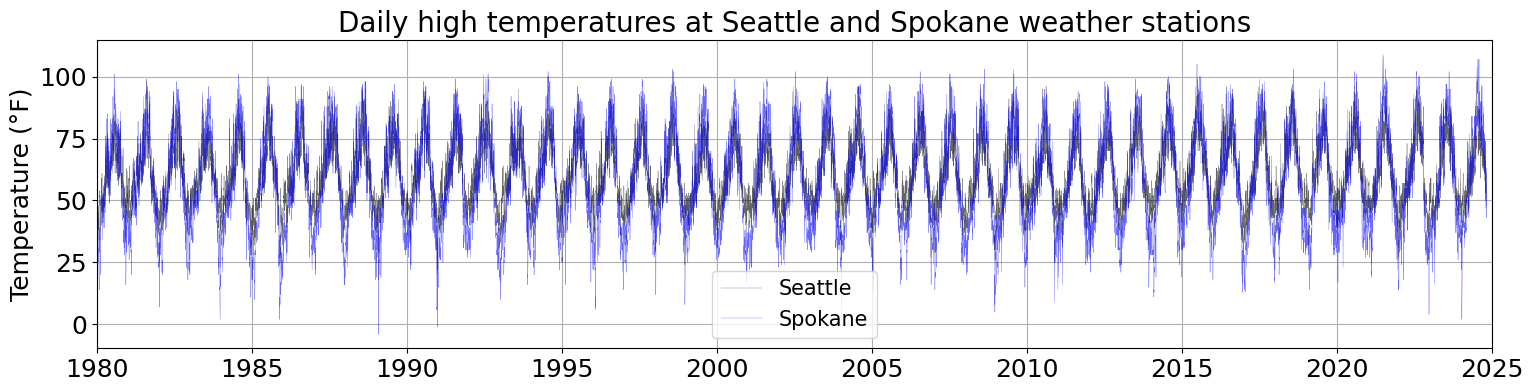

In [4]:
# Plot of the high temperature data
plt.figure(figsize=(18, 4))
plt.plot(seattle['TMAX'].index.values, seattle['TMAX'].values,
         c='k', 
         lw=0.25, 
         alpha=0.6, 
         label='Seattle')
plt.plot(spokane['TMAX'].index.values, spokane['TMAX'].values,
         c='b', 
         lw=0.25, 
         alpha=0.6, 
         label='Spokane')
plt.grid()
plt.legend(fontsize=15)
plt.ylabel('Temperature (°F)', fontsize=18)
plt.xlim([datetime(1980, 1, 1), datetime(2025, 1, 1)])
plt.gca().tick_params(axis='both', labelsize=18) # increase font size of tick numbers
plt.title('Daily high temperatures at Seattle and Spokane weather stations', fontsize=20);

### Use `.groupby()` to calculate climatologies and annual averages

If a Pandas Series or DataFrame's index has datetimes, it's called a `DatetimeIndex`. `DatetimeIndex` objects have a few useful attributes:

* `.year`
* `.month`
* `.day`
* `.dayofyear`  (day-of-year goes from 1-366)

In [5]:
# This finds the year for each date
seattle.index.year

Index([1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980,
       ...
       2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024],
      dtype='int32', name='DATE', length=16379)

In [6]:
# This finds the day-of-year for each date
seattle.index.dayofyear

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       299, 300, 301, 302, 303, 304, 305, 306, 307, 308],
      dtype='int32', name='DATE', length=16379)

In [7]:
# We can group the data by day-of-year, then calculate the average over 
# each day-of-year, for each column
#
# This type of average is called a "climatology"
seattle_clim = seattle.groupby(seattle.index.dayofyear).mean(numeric_only=True)
spokane_clim = spokane.groupby(spokane.index.dayofyear).mean(numeric_only=True)

# See result
display(seattle_clim)

,PRCP,TMAX,TMIN
DATE,,,
1,0.164444,45.777778,35.977778
2,0.266000,45.688889,35.466667
3,0.153556,46.266667,36.044444
4,0.202222,46.088889,36.244444
5,0.219778,45.333333,36.177778
...,...,...,...
362,0.123023,45.363636,36.045455
363,0.182500,44.681818,35.500000
364,0.175349,45.409091,35.409091


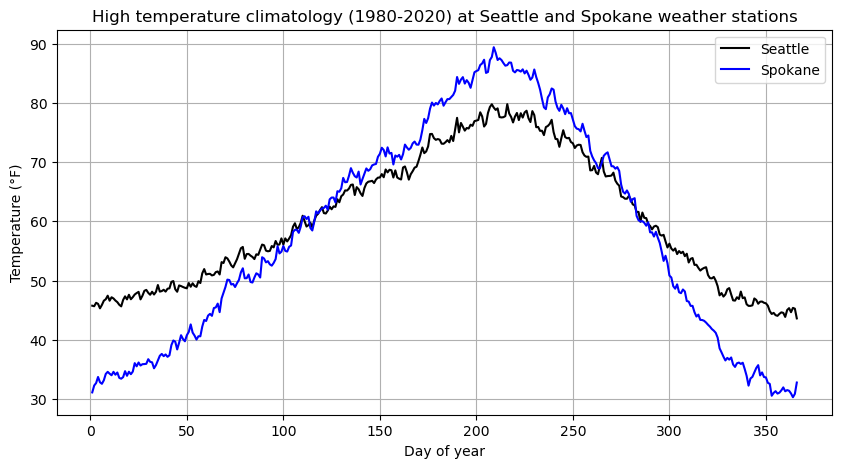

In [8]:
# Plot of climatologies
plt.figure(figsize=(10, 5))
plt.plot(seattle_clim.index, seattle_clim['TMAX'].values, c='k', label='Seattle')
plt.plot(spokane_clim.index, spokane_clim['TMAX'].values, c='b', label='Spokane')
plt.grid()
plt.legend()
plt.xlabel('Day of year')
plt.ylabel('Temperature (°F)')
plt.title('High temperature climatology (1980-2020) at Seattle and Spokane weather stations');

In [9]:
# We can group the data by year, then calculate the annual averages for each column
seattle_ann = seattle.groupby(seattle.index.year).mean(numeric_only=True)
spokane_ann = spokane.groupby(spokane.index.year).mean(numeric_only=True)

# See result
display(seattle_ann)

,PRCP,TMAX,TMIN
DATE,,,
1980,0.097268,58.368852,44.314208
1981,0.096986,60.010959,45.287671
1982,0.107726,58.715068,43.978082
1983,0.112137,59.564384,45.824658
1984,0.101066,58.639344,44.338798
1985,0.068849,57.627397,42.273973
1986,0.105041,60.449315,45.367123
1987,0.082000,62.142466,45.142466
1988,0.090109,60.251366,44.568306


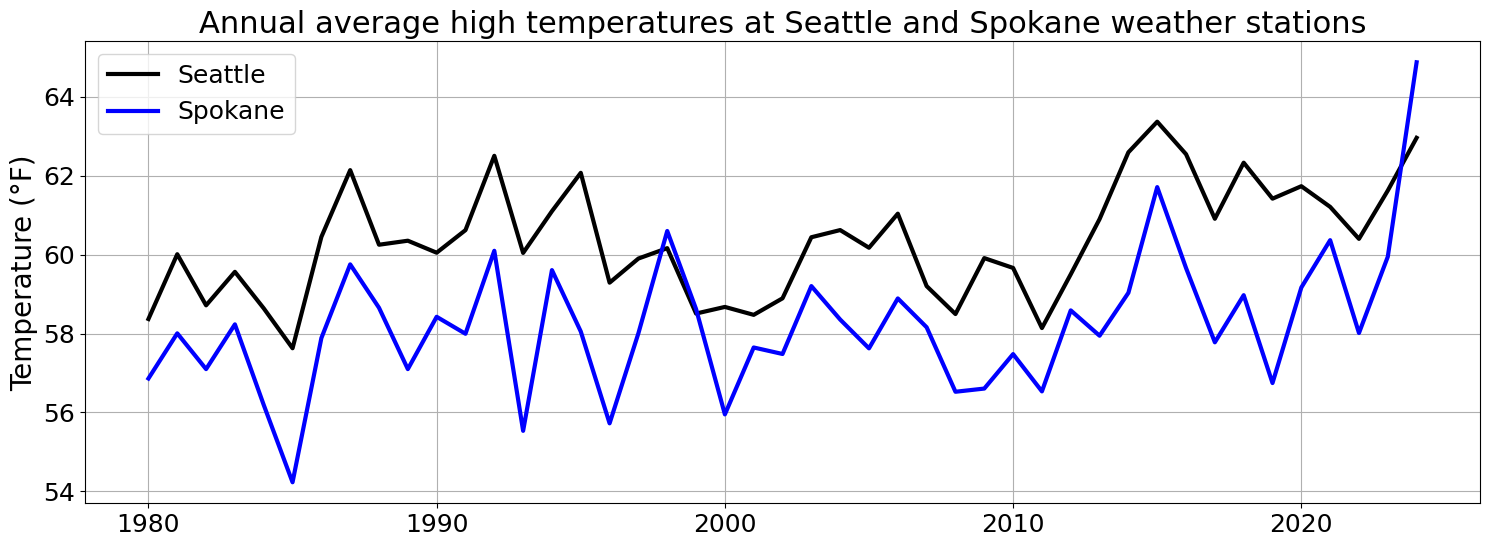

In [10]:
# Plot of the annual average high temperature data
plt.figure(figsize=(18, 6))
plt.plot(seattle_ann['TMAX'].index.values,seattle_ann['TMAX'].values, 
         c='k', 
         lw=3, 
         label='Seattle')
plt.plot(spokane_ann['TMAX'].index.values,spokane_ann['TMAX'].values, 
         c='b', 
         lw=3, 
         label='Spokane')
plt.grid()
plt.legend(fontsize=18)
plt.ylabel('Temperature (°F)', fontsize=20)
plt.gca().tick_params(axis='both', labelsize=18) # increase font size of tick numbers
plt.title('Annual average high temperatures at Seattle and Spokane weather stations',
         fontsize=22);

### Calculating correlations using `.corr()`

Recall that a column of a Pandas DataFrame is a Pandas Series.

We can correlate two Pandas Series objects, `s1` and `s2`, using the following syntax:

> `s1.corr(s2)`

The result is the standard Pearson correlation coefficient, $r$.

More commonly, however, you'll use $r^2$. As I introduced in Lesson #14, $r^2$ represents the proportion of variance in one variable that is explained by the other variable.

API documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

In [11]:
# Correlate annual average high temperatures from Seattle and Spokane
#
# Note that we provide the entire Pandas Series, not just the .values or the .index
r = seattle_ann['TMAX'].corr(spokane_ann['TMAX'])
print('The r^2 value is:', r**2)

The r^2 value is: 0.5216576427179345


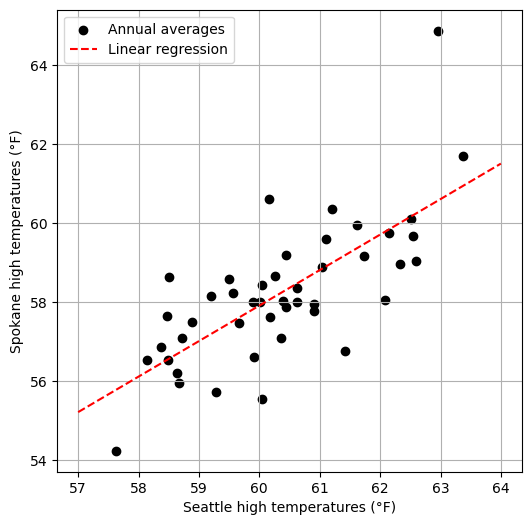

In [12]:
# In other words, there's clearly a relationship between annual-average 
# temperatures in Seattle and Spokane.
#
# This plot shows that close relationship, and also shows the regression line.
#
# The r^2 value tells us that 50% of the variance of annual-average 
# temperatures in Spokane can be explained by the annual-average 
# Seattle temperatures.

# Linear regression using SciPy (see Lesson #14 for details)
slope,intercept, _, _, _ = stats.linregress(
    seattle_ann['TMAX'].values, spokane_ann['TMAX'].values
)

# Make plot
plt.figure(figsize=(6, 6))
plt.scatter(seattle_ann['TMAX'], spokane_ann['TMAX'], 
            c='k', 
            label='Annual averages')
plt.plot(np.arange(57,65), slope * np.arange(57,65) + intercept,
         c='r', 
         ls='--', 
         label='Linear regression')
plt.legend()
plt.grid()
plt.xlabel('Seattle high temperatures (°F)')
plt.ylabel('Spokane high temperatures (°F)');

### Changing the time resolution using `.resample()`

We can down-sample the time resolution of a Pandas Series or DataFrame if it has datetimes as its index, i.e. a `DatetimeIndex`.

The function `.resample()` takes a "frequency alias" or "offset alias" as its argument. It behaves similar to `.groupby()`, so after you group the data, you have to apply a function like `.mean()`, `.max()`, or `.sum()`.

Here are the available frequency aliases: https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases

Some common options are:
* 'H': hourly frequency
* 'D': daily frequency
* 'W': weekly frequency
* 'MS': monthly frequency (use start of month as resulting date)
* 'YS': yearly frequency (use start of year as resulting date)

API documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html

In [13]:
# Calculate annual averages using .resample() instead of .groupby()
seattle['TMAX'].resample('YS').mean()

DATE
1980-01-01    58.368852
1981-01-01    60.010959
1982-01-01    58.715068
1983-01-01    59.564384
1984-01-01    58.639344
1985-01-01    57.627397
1986-01-01    60.449315
1987-01-01    62.142466
1988-01-01    60.251366
1989-01-01    60.353425
1990-01-01    60.049315
1991-01-01    60.621918
1992-01-01    62.505464
1993-01-01    60.043836
1994-01-01    61.101370
1995-01-01    62.073973
1996-01-01    59.289617
1997-01-01    59.901370
1998-01-01    60.164384
1999-01-01    58.506849
2000-01-01    58.674863
2001-01-01    58.473973
2002-01-01    58.893151
2003-01-01    60.441096
2004-01-01    60.622951
2005-01-01    60.175342
2006-01-01    61.038356
2007-01-01    59.202740
2008-01-01    58.494536
2009-01-01    59.912329
2010-01-01    59.663014
2011-01-01    58.139726
2012-01-01    59.502732
2013-01-01    60.901370
2014-01-01    62.594521
2015-01-01    63.369863
2016-01-01    62.546448
2017-01-01    60.909589
2018-01-01    62.331507
2019-01-01    61.419178
2020-01-01    61.734973
2021-01-01 

### Smoothing data using `.rolling()` averages

A common technique to smooth a time series (or other data) is to calculate a rolling average, also called a running average, running mean, or moving average:

> `.rolling(window,min_periods=1,center=False)`

* `window` specifies the size of the moving window in number of rows
* `min_periods` specifies the minimum number of rows required to have data (otherwise the result is np.NaN); this is important at the start and end of the time series
* if `center` is True (recommended), the date will be set to center of each window; if False, the date will be set to the end of each window

Again, `.rolling()` behaves similar to `.groupby()` and `.resample()` in that you have to apply a function like `.mean()` or `.median()` to the grouped data to get a result.

API documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html

In [14]:
# Smooth annual average temperatures using a 5-year running mean
seattle_ann_rm = seattle_ann['TMAX'].rolling(window=5, center=True).mean()
spokane_ann_rm = spokane_ann['TMAX'].rolling(window=5, center=True).mean()

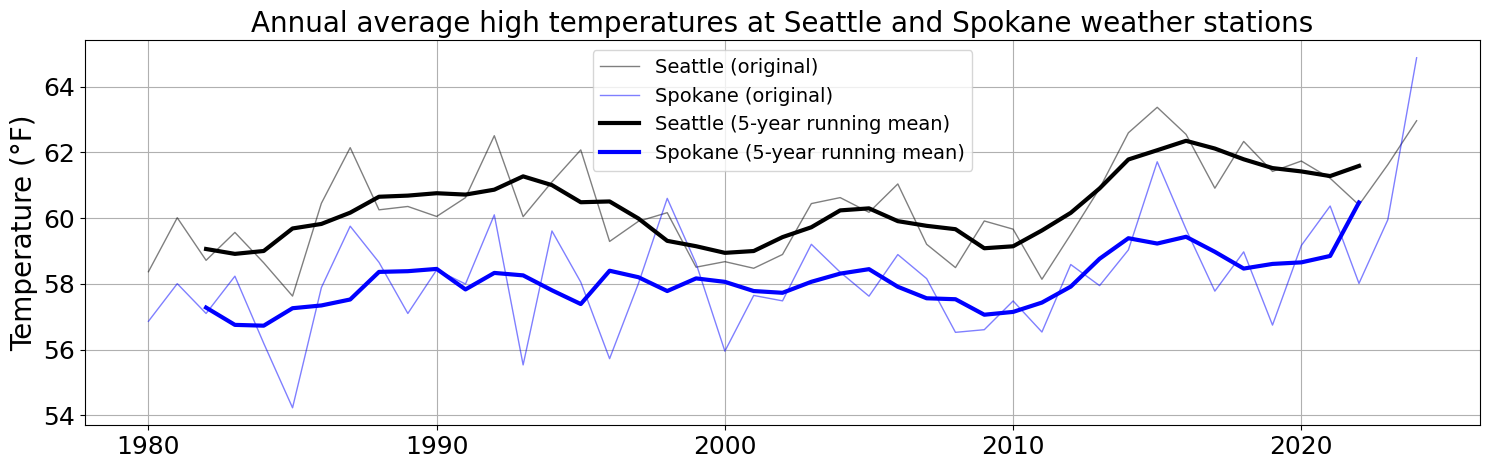

In [15]:
# Plot
plt.figure(figsize=(18, 5))
plt.plot(seattle_ann['TMAX'].index.values, seattle_ann['TMAX'].values, 
         c='k', 
         lw=1, 
         alpha=0.5, 
         label='Seattle (original)')
plt.plot(spokane_ann['TMAX'].index.values, spokane_ann['TMAX'].values,
         c='b', 
         lw=1, 
         alpha=0.5, 
         label='Spokane (original)')
plt.plot(seattle_ann_rm, c='k', lw=3, label='Seattle (5-year running mean)')
plt.plot(spokane_ann_rm, c='b', lw=3, label='Spokane (5-year running mean)')
plt.grid()
plt.legend(fontsize=14)
plt.ylabel('Temperature (°F)', fontsize=20)
plt.gca().tick_params(axis='both', labelsize=18)
plt.title('Annual average high temperatures at Seattle and Spokane weather stations',
         fontsize=20);

In [16]:
# Smooth high temperature climatologies using a 30-day running mean
seattle_clim_rm = seattle_clim['TMAX'].rolling(window=30, center=True, min_periods=1).mean()
spokane_clim_rm = spokane_clim['TMAX'].rolling(window=30, center=True, min_periods=1).mean()

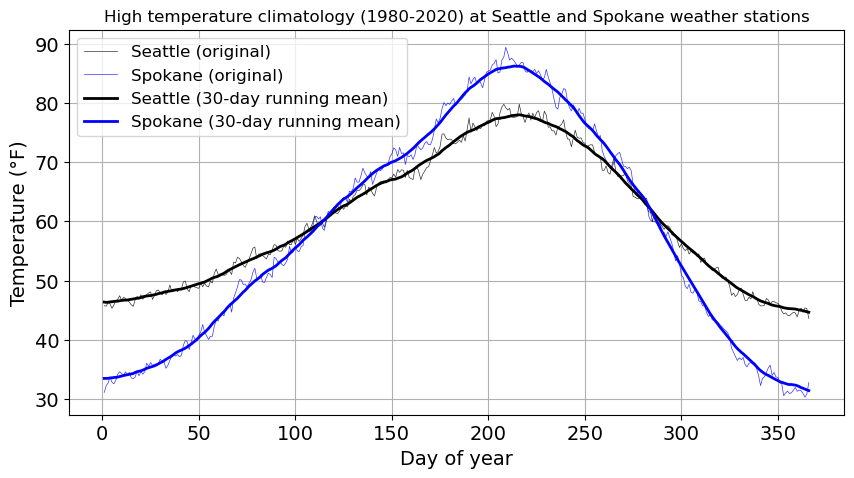

In [17]:
# Plot of climatologies
plt.figure(figsize=(10, 5))
plt.plot(seattle_clim.index, seattle_clim['TMAX'].values,
         c='k', 
         lw=0.5, 
         alpha=0.8, 
         label='Seattle (original)')
plt.plot(spokane_clim.index, spokane_clim['TMAX'].values,
         c='b', 
         lw=0.5, 
         alpha=0.8, 
         label='Spokane (original)')
plt.plot(seattle_clim_rm, 
         c='k', 
         lw=2, 
         label='Seattle (30-day running mean)')
plt.plot(spokane_clim_rm, 
         c='b', 
         lw=2, 
         label='Spokane (30-day running mean)')
plt.grid()
plt.legend(fontsize=12)
plt.xlabel('Day of year', fontsize=14)
plt.ylabel('Temperature (°F)', fontsize=14)
plt.gca().tick_params(axis='both', labelsize=14)
plt.title('High temperature climatology (1980-2020) at Seattle and Spokane weather stations');